In [1]:
import os
import json
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime


def analyze_tls_certificates(root_folder):
    all_data = []

    for province_folder in os.listdir(root_folder):
        province_path = os.path.join(root_folder, province_folder)

        if os.path.isdir(province_path):
            for json_file in os.listdir(province_path):
                json_file_path = os.path.join(province_path, json_file)

                if os.path.isfile(json_file_path) and json_file.endswith(".json"):
                    with open(json_file_path, 'r', encoding='utf-8') as f:
                        json_data = json.load(f)
                        all_data.append(json_data)

    return all_data
# 设置你的根目录
root_folder = "./ca"
all_data = analyze_tls_certificates(root_folder)

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

def analyze_country_and_organization(data):
    print("Country and Organization Analysis:")
    countries = [item.get("issuer", [])[0][0][1] for item in data]
    organizations = [item.get("issuer", [])[1][0][1] if len(item.get("issuer", [])) > 1 else "" for item in data]

    # 创建第一个图，国家分布图
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    country_counts = Counter(countries)
    
    # Use a colormap for different colors in fig1
    country_colors = plt.cm.tab10(range(len(country_counts)))
    ax1.bar(country_counts.keys(), country_counts.values(), color=country_colors, edgecolor='black')
    ax1.set_title("Countries Distribution")
    ax1.set_xlabel("Country")
    ax1.set_ylabel("Count")

    # 在国家图中添加数字标签
    for i, v in enumerate(country_counts.values()):
        ax1.text(i, v + 0.1, str(v), color='black', ha='center')

    plt.tight_layout()  # 调整布局，防止重叠
    plt.show()

    # 创建第二个图，组织分布图
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    organization_counts = Counter(organizations)

    # Use a colormap for different colors in fig2
    organization_colors = plt.cm.tab20(range(len(organization_counts)))
    ax2.bar(range(len(organization_counts)), organization_counts.values(), color=organization_colors, edgecolor='black')
    ax2.set_title("Organizations Distribution")
    ax2.set_xlabel("Organization Index")
    ax2.set_ylabel("Count")

    # 在组织图中添加数字标签
    for i, v in enumerate(organization_counts.values()):
        ax2.text(i, v + 0.1, str(v), color='black', ha='center')

    # 在组织图中添加说明信息
    ax2.set_xticks(range(len(organization_counts)))
    ax2.set_xticklabels(list(organization_counts.keys()), rotation=45, ha='right')

    plt.tight_layout()  # 调整布局，防止重叠
    plt.show()

    return country_counts, organization_counts


In [3]:
def analyze_certificate_versions(data):
    print("Certificate Versions Analysis:")
    versions = [cert.get("version", "") for item in data for cert in item.get("cert_chain", [])]

    # 绘制证书版本分布图
    plt.bar(Counter(versions).keys(), Counter(versions).values(), color='lightgreen', edgecolor='black')
    plt.title("Certificate Versions Distribution")
    plt.xlabel("Certificate Version")
    plt.ylabel("Count")
    plt.show()
    return versions

In [4]:
def analyze_tls_version(data):
    tls_versions = Counter(item.get("tls_version", "") for item in data)

    # 绘制 TLS 版本分布图
    plt.bar(tls_versions.keys(), tls_versions.values(), color='lightblue', edgecolor='black')
    plt.title("TLS Versions Distribution")
    plt.xlabel("TLS Version")
    plt.ylabel("Count")
    plt.show()
    return tls_versions

In [5]:
def analyze_certificate_validity_period(data):
    valid_from_dates = [datetime.strptime(item.get("valid_from", ""), "%b %d %H:%M:%S %Y %Z") for item in data]
    valid_until_dates = [datetime.strptime(item.get("valid_until", ""), "%b %d %H:%M:%S %Y %Z") for item in data]

    # 绘制证书有效期时间序列图
    plt.figure(figsize=(12, 6))
    plt.plot(valid_from_dates, label='Valid From', marker='o', linestyle='-', color='orange')
    plt.plot(valid_until_dates, label='Valid Until', marker='o', linestyle='--', color='purple')
    plt.title("Certificate Validity Period")
    plt.xlabel("Certificate Index")
    plt.ylabel("Date")
    plt.legend()
    plt.show()

    return valid_from_dates, valid_until_dates

D:\PyCharmProject\WebsiteCollectAndAnalysis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


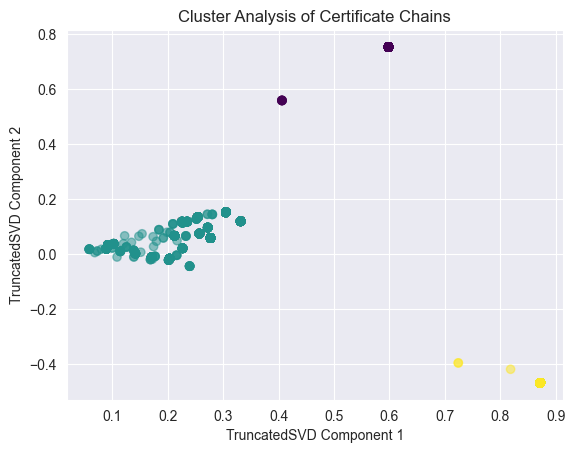

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# 创建DataFrame
df = pd.json_normalize(all_data)

# 选择要使用的列
text_data = df['issuer'].astype(str)  # 将列转换为字符串

# 使用TF-IDF向量化文本
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text_data)

# 使用TruncatedSVD降维
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)

# 使用K-means聚类
kmeans = KMeans(n_clusters=3)
df['cluster'] = kmeans.fit_predict(X_svd)

# 绘制聚类结果
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('Cluster Analysis of Certificate Chains')
plt.xlabel('TruncatedSVD Component 1')
plt.ylabel('TruncatedSVD Component 2')
plt.show()

In [8]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns

# Create a DataFrame from the JSON data
df = pd.json_normalize(all_data)


df.describe()

,hostname,issuer,subject,valid_from,valid_until,cert_chain,tls_version
count,2204,2204,2204,2204,2204,2204,2204
unique,2129,57,878,710,711,4,2
top,cjhy.mot.gov.cn,"[[[countryName, CN]], [[organizationName, Glob...","[[[countryName, CN]], [[stateOrProvinceName, 北...",Nov 17 00:00:00 2022 GMT,Nov 16 23:59:59 2023 GMT,"[{'subject': [[['commonName', 'XunYouRootCA']]...",TLSv1.2
freq,2,524,54,60,92,1279,1234


In [9]:
import plotly.graph_objects as go
import networkx as nx
import plotly.io as pio

# Create a directed graph
G = nx.DiGraph()
count = 0

# Add nodes and edges from certificate chains
for data in all_data:
    cert_self = data['issuer'][-1][-1][-1]
    G.add_node(cert_self, label=cert_self)
    G.add_edge(cert_self, cert_self)
    pre_issuer = cert_self
    cert_chain = data.get('cert_chain', [])
    for i in range(len(cert_chain) - 1):
        # Find the 'organizationName' or 'commonName' in 'issuer'
        issuer = next((item[-1] for item in cert_chain[i]['issuer'][-1] if item[0] in ['organizationName', 'commonName']), None)
    
        if issuer is not None:
            count += 1
    
            # Add nodes if not already added
            G.add_node(issuer, label=issuer)
    
            # Add edges to represent the certificate chain
            if pre_issuer is not None:
                G.add_edge(pre_issuer, issuer)  # Edge from pre_issuer to the current issuer
    
            # Update pre_issuer for the next iteration
            pre_issuer = issuer

# Customize the layout and add labels
pos = nx.spring_layout(G)
pos = {k: [v[1], -v[0]] for k, v in pos.items()}  # Swap x and y coordinates

edge_trace = go.Scatter(x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')
node_trace = go.Scatter(x=[], y=[], text=[], mode='markers+text', hoverinfo='text', marker=dict(showscale=False, colorscale='YlGnBu', size=10, colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right')), textposition='bottom center')

label_interval = 5  # Display label for every 5th node
key_nodes = set(G.nodes())  # You can specify key nodes here

for i, edge in enumerate(G.edges()):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

for i, node in enumerate(G.nodes()):
    x, y = pos[node]
    if i % label_interval == 0 :
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['text'] += tuple([G.nodes[node]['label']])

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0,l=0,r=0,t=0),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                width=1000,  # 调整图的宽度
                height=1000  # 调整图的高度
             ))

pio.write_image(fig, "cert_chain.png")
# Show the figure
fig.show()




# Convert directed graph to undirected for visualization
G_undirected = G.to_undirected()
nx.write_gexf(G, "graph.gexf")
nx.write_gexf(G_undirected, "un_graph.gexf")


# General graph characteristics
print("Number of Nodes:", G.number_of_nodes())
print("Number of Edges:", G.number_of_edges())
print("Average Degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())

# Centrality Measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Closeness Centrality:", closeness_centrality)

# Connected Components
connected_components = list(nx.strongly_connected_components(G))
print("Connected Components:", connected_components)

# PageRank Algorithm
pagerank_scores = nx.pagerank(G)
print("PageRank Scores:", pagerank_scores)

# Community Detection (Louvain Method) on the undirected graph
louvain_communities = list(nx.community.label_propagation_communities(G_undirected))
print("Louvain Communities:", louvain_communities)


# 
# degrees = dict(G.degree())
# plt.hist(list(degrees.values()), bins=20)
# plt.title('Node Degrees Distribution')
# plt.xlabel('Node Degree')
# plt.ylabel('Frequency')
# plt.show()
# 
# pos = nx.spring_layout(G)
# for component in connected_components:
#     subgraph = G.subgraph(component)
#     nx.draw(subgraph, pos, with_labels=True, font_weight='bold', node_size=1000, font_size=8, arrowsize=10)
#     plt.title('Strongly Connected Component')
#     plt.show()
#     
# pos = nx.spring_layout(G_undirected)
# for i, community in enumerate(louvain_communities):
#     subgraph = G_undirected.subgraph(community)
#     nx.draw(subgraph, pos, with_labels=True, font_weight='bold', node_size=1000, font_size=8, arrowsize=10)
#     plt.title(f'Community {i + 1}')
#     plt.show()


print(count)

ValueError: Failed to start Kaleido subprocess. Error stream:

[1022/145316.270:WARNING:resource_bundle.cc(405)] locale_file_path.empty() for locale 
[1022/145316.293:WARNING:headless_browser_main_parts.cc(83)] Cannot create Pref Service with no user data dir.
[1022/145316.320:ERROR:gpu_init.cc(430)] Passthrough is not supported, GL is swiftshader
[1022/145353.655:WARNING:gpu_process_host.cc(1295)] The GPU process has crashed 1 time(s)
[1022/145353.671:ERROR:network_service_instance_impl.cc(330)] Network service crashed, restarting service.


In [ ]:
a,b = analyze_country_and_organization(all_data)

In [26]:
print(b)

Counter({'Global Digital Cybersecurity Authority Co., Ltd.': 523, 'DigiCert Inc': 506, 'China Financial Certification Authority': 424, 'TrustAsia Technologies, Inc.': 188, 'UniTrust': 160, 'Greater Manchester': 105, 'Beijing Xinchacha Credit Management Co., Ltd.': 70, 'GlobalSign nv-sa': 62, 'WoTrus CA Limited': 29, 'DNSPod, Inc.': 25, 'DigiCert, Inc.': 23, 'Xin Net Technology Corp.': 23, 'Shenzhen Digital Certificate Authority Center Co., Ltd': 9, "Let's Encrypt": 8, 'iTrusChina Co., Ltd.': 7, 'sslTrus': 5, 'Beijing ZhongWan Network Technology Co Ltd': 2})


In [ ]:
analyze_certificate_versions(all_data)

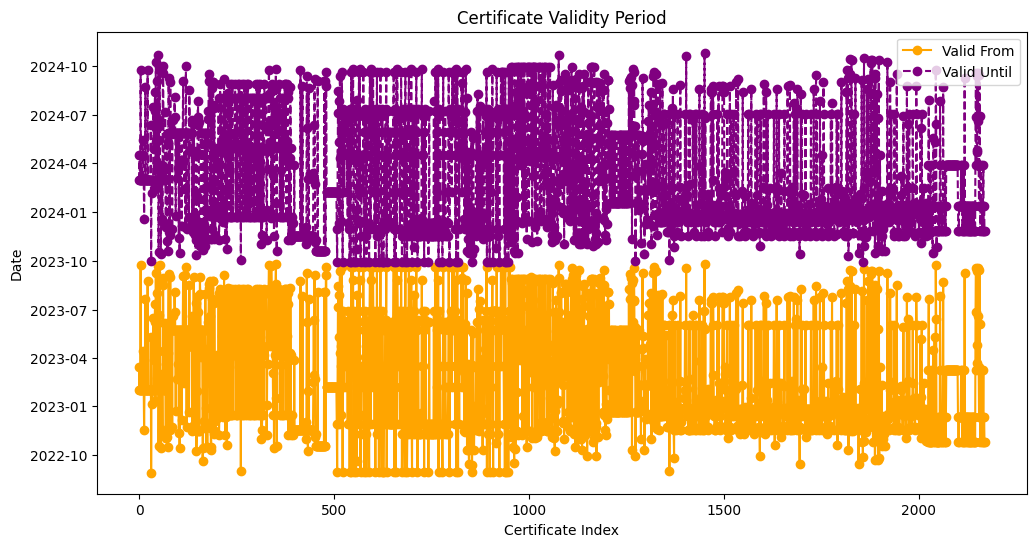

([datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 3, 16, 2, 12, 20),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 9, 22, 1, 17, 1),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 3, 16, 2, 12, 20),
  datetime.datetime(2023, 4, 14, 3, 5, 25),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2022, 11, 17, 7, 11, 46),
  datetime.datetime(2023, 2, 3, 9, 4, 37),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 7, 21, 7, 28, 6),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.datetime(2023, 1, 31, 6, 12, 26),
  datetime.dat

In [8]:
analyze_certificate_validity_period(all_data)

In [ ]:
analyze_tls_version(all_data)